## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [4]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [9]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root'

In [10]:
branches = [
            'B0_TAGOMEGA_OS',
            'B0_TAGDECISION_OS',
            'B0_FitPVConst_tau_flat',
            'B0_FitPVConst_tauErr_flat',
            'B0_TRUETAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber',
            'idxPV',
            'Delta_TAU',
            'BDTresponse_wrongPV'
            ]


In [12]:
tree_mc = 'Bd2JpsiKS'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [13]:
signal_dataframe_wrongPV.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key='Bd2JpsiKS')

In [14]:
# Read data and fit it
dataset_file_name = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/interim.root'
data = ROOT.TFile(dataset_file_name)
dataset_tree = data.Get('Bd2JpsiKS') 
dataset_tree.GetEntries()



178802

### Function to calculate the FOMs

### Configure  and define cuts 

In [15]:
lowerbound=5220 # rather arbitrary signal window definition
upperbound=5450
#B0_FitDaughtersConst_M.setRange('SIGREGION',lowerbound,upperbound)

subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
mass_var_name = 'B0_FitDaughtersConst_M'
cuttype = 'BDTresponse_wrongPV'#'B0_TAUERR'#

cuts = np.linspace(0,10,30) #(0,20,10)    #(0,0.001,10)
#cuts = [-0.05]
cuts_for_which_to_store_sdata = []   

num_sig = []
num_bkg = []
num_all = []

cut_to_performance = {} 
cut_to_shape = {}

perform_fit = True
do_splot    = True
postfix = ''
final_params_file = None
oldParameters = None
final_model = None

### Calculate FOM

In [38]:
def calculate_foms(data_fit_cut,best_pv): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    timeres_power = 0
    tagging_power = 0
    
    D_bs_perfect  = 0
    D_bs_perftagg = 0
    D_bs_perfterr = 0
    D_bs          = 0
    D_bd          = 0
    D_bd_perfect  = 0
    Q_bs_perfect  = 0
    Q_bs_perftagg = 0
    Q_bs_perfterr = 0
    Q_bs          = 0
    Q_bd          = 0
    Q_bd_perfect  = 0
    
    signal_sum_tag_decis = 0 # count two ways to check consistency
    signal_sum_tag_omega = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)
    


    

    
    tagomega = np.array(data_fit_cut['B0_TAGOMEGA_OS'])
    tag1 = np.array(data_fit_cut['B0_TAGDECISION_OS'])
    time = np.array(data_fit_cut['B0_FitPVConst_tau_flat']) 
    error = np.absolute(np.array(data_fit_cut['B0_FitPVConst_tauErr_flat']))#'Delta_TAU']))
    
    ##################################################################
    
    for i in range(data_fit_cut.shape[0]):
        signal_weight =  1 
        cbkg_weight   =  1 
        mistag        =  tagomega[i] 
        tag           =  tag1[i]
        decaytime     =  time[i]
        timeerror     =  error[i]
        
        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        
        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)
    
        timeres_power     += timeerror_dilution *signal_weight 
        
        timeres_power /= signal_sum  
       # fomname_to_value.update({'TimeresPower' : timeres_power})
        
        nominator_bd_term   = math.sin(delta_m * decaytime)
        denominator_bd_term = 1 + tag * (1 - 2 * mistag) * S * math.exp(-0.5*(delta_m*timeerror)**2)*math.sin(delta_m*decaytime)       
        bd_term = (nominator_bd_term/denominator_bd_term)**2
        
        #case of perfect flavour tagging and no time-dilution effect 
        denominator_bd_term_perfect = 1 + tag * 1 * S * 1 *math.sin(delta_m*decaytime)
        bd_term_perfect = (nominator_bd_term/denominator_bd_term_perfect)**2
        
        tagging_dilution  = (1 - 2*mistag)**2
        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)

        timeres_power    += timeerror_dilution*signal_weight
        tagging_power    += tagging_dilution*signal_weight
        
        D_bs_perfect      += 1                * 1                  * 1               * signal_weight
        D_bs_perftagg     += 1                * timeerror_dilution * 1               * signal_weight
        D_bs_perfterr     += tagging_dilution * 1                  * 1               * signal_weight
        D_bs              += tagging_dilution * timeerror_dilution * 1               * signal_weight
        D_bd              += tagging_dilution * timeerror_dilution * bd_term         * signal_weight
        D_bd_perfect      += 1                * 1                  * bd_term_perfect * signal_weight

    effsigsize = signal_sum**2 / signal_sumw2
    
    if (signal_sum_tag_omega != signal_sum_tag_decis):
        print('ERROR: counting sweights via omega!=0.5 and decision!=0 led to different results')
        print('ERROR: this should not happen! - tagging efficiency is not well defined')
        print('ERROR: omega counting: {}   tag counting: {}'.format(signal_sum_tag_omega, signal_sum_tag_decis))
        
    tagging_dilution_avg_tagged = tagging_power / signal_sum_tag_omega
    tagging_efficiency = signal_sum_tag_omega / signal_sum
    
    tagging_power /= signal_sum
    timeres_power /= signal_sum

    D_bs_perfect  /= signal_sum#dataset.numEntries()
    D_bs_perftagg /= signal_sum#dataset.numEntries()
    D_bs_perfterr /= signal_sum#dataset.numEntries()
    D_bs          /= signal_sum#dataset.numEntries()
    D_bd          /= signal_sum#dataset.numEntries()
    D_bd_perfect  /= signal_sum#dataset.numEntries()
        
    Q_bs_perfect  = effsigsize * D_bs_perfect #signal_sum**2 / dataset.numEntries() * D_bs_perfect
    Q_bs_perftagg = effsigsize * D_bs_perftagg #signal_sum**2 / dataset.numEntries() * D_bs_perftagg
    Q_bs_perfterr = effsigsize * D_bs_perfterr #signal_sum**2 / dataset.numEntries() * D_bs_perfterr
    Q_bs          = effsigsize * D_bs #signal_sum**2 / dataset.numEntries() * D_bs
    Q_bd          = effsigsize * D_bd #signal_sum**2 / dataset.numEntries() * D_bd
    Q_bd_perfect  = effsigsize * D_bd_perfect #signal_sum**2 / dataset.numEntries() * D_bd
    
    
    
    fomname_to_value = {
        'EffSigSize'   : effsigsize,
        'TaggingPower' : tagging_power,
        'TaggingDavg'  : tagging_dilution_avg_tagged,
        'TaggingEff'   : tagging_efficiency,
        'TimeresPower' : timeres_power,
        'BsFOM_p'      : Q_bs_perfect,
        'BsFOM_pTim'   : Q_bs_perfterr,
        'BsFOM_pTag'   : Q_bs_perftagg,
        'BsFOM'        : Q_bs,
        'BdFOM'        : Q_bd,
        'BdFOM_p'      : Q_bd_perfect,
        'signal_sum'   : signal_sum,
        'signal_weight': signal_weight
    }

    return fomname_to_value

In [39]:
from ROOT import RooArgList
import subprocess, os
import time
import root_pandas as rp

x=None
for cut in cuts:
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(cuttype,cut), flush=True)
    data_fit_cut = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)) #data_after_import.reduce('{0}>{1}'.format(cuttype,cut))
    best_pv = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)).query('idxPV==0')
    #data_fit_cut = data_fit_cut.query('B0_FitPVConst_MinIPCHI2anyPV_flat>6')
    #print("The size of the sample is:")
    #print(data_fit_cut['Delta_TAU'].min())
    data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    print('INFO: Call CandidateSelectionGrimReaper', flush=True)
    my_env = os.environ.copy()
    my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
    my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
    my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
    my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
             'lb-run DaVinci/v41r2 $BASH -c "' \
             'echo $PATH && ' \
             'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS "idxRunNumber""'                     
    subprocess.Popen([my_command], env=my_env, shell=True)
   # subprocess.call(('bash /home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection/random_sel.sh'),shell=True)                      
    print("Wait for GrimReaper")
    time.sleep(40.0)    # pause 5.5 seconds
    print("GrimReaper hopefully finished")
    print('INFO: Read selected data', flush=True)
    data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    print('INFO: Start Calculation', flush=True)
    #print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
    #final_model = build_mass_model(B0_FitDaughtersConst_M)
    
    cut_to_shape[cut] = {} 
    cut_to_performance[cut] = {}
   
    
    foms = calculate_foms(data_fit_cut,best_pv)
    cut_to_performance[cut].update(foms)
    
    print('INFO: Finish Calculation', flush=True)

INFO: Starting to test cut BDTresponse_wrongPV<0.0
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrongPV<0.3448275862068966


/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/ipykernel/__main__.py:91: RuntimeWarning: divide by zero encountered in double_scalars


INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrongPV<0.6896551724137931
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrongPV<1.0344827586206897
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrongPV<1.3793103448275863
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrongPV<1.7241379310344829
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully

KeyError: 'B0_FitPVConst_tau_flat'

In [40]:
import numpy as np

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


### Plot FOMs

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


ValueError: x and y must have same first dimension

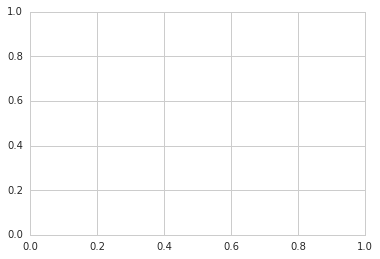

In [47]:
import random
import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"legend.frameon": True})

x, ys = unpack_cut_dict(cut_to_performance)
shift = 0.0

foms_to_plot = {}
#foms_to_plot["TaggingPower"] = r"Flavour Tagging"
foms_to_plot["TimeresPower"] = "Best PV selection"
foms_to_plot["TimeresPower"]   = "Random PV selection"
#foms_to_plot["BsFOM"]        = "$X_i$-term"
#foms_to_plot["BdFOM_p"]      = "FOM ${}_{B^0_d}$"
#foms_to_plot["BdFOM"]        = "FOM"

#for parameter, values in ys.items():
for parameter in foms_to_plot:
    values=ys[parameter]
    #if "FOM" in parameter or "EffSig" in parameter or "s3_over_spb2" in parameter\
    #or "TaggingPower" in parameter or "TimeresPower" in parameter:
    if parameter in foms_to_plot:
        plt.errorbar(x,values+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter])
        plt.xlabel("Delta_TAU cut")
'''values_EffSigSize=ys['EffSigSize']
values_TimeresPower=ys['TimeresPower']
values_TaggingPower=ys['TaggingPower']
values_BdFOM_p=ys['BdFOM_p']
values_BdFOM=ys['BdFOM']


plt.errorbar(x,values_EffSigSize+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[0])
plt.errorbar(x,values_TimeresPower+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[1])
plt.errorbar(x,values_TaggingPower+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[2])
plt.errorbar(x,values_BdFOM_p+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[3])
plt.errorbar(x,values_BdFOM+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[4])
plt.xlabel("BDT Schnitt")'''
plt.gca().set_ylim(0.94,1.001)
plt.gca().set_xlim(0.0000000001,0.02)
plt.legend(loc='best')
plt.savefig(subdir + '/FOMS.pdf')
plt.show()